# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training LSTM Model to predict RUL</a>
+ <a href='#testing_var'>4. Testing VAR</a>
+ <a href='#health_score'>5 Health Score Assignment</a>
+ <a href='#pred_analysis'>6. Analysing Prediction</a>

In [263]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from keras.models import load_model

# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [264]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [265]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [266]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [267]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [268]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


In [269]:
for i in range(26):
    print(str(i))
    print(df['Section-'+str(i)])

0
0          1
1          1
2          1
3          1
4          1
        ... 
20626    100
20627    100
20628    100
20629    100
20630    100
Name: Section-0, Length: 20631, dtype: int64
1
0          1
1          2
2          3
3          4
4          5
        ... 
20626    196
20627    197
20628    198
20629    199
20630    200
Name: Section-1, Length: 20631, dtype: int64
2
0       -0.0007
1        0.0019
2       -0.0043
3        0.0007
4       -0.0019
          ...  
20626   -0.0004
20627   -0.0016
20628    0.0004
20629   -0.0011
20630   -0.0032
Name: Section-2, Length: 20631, dtype: float64
3
0       -0.0004
1       -0.0003
2        0.0003
3        0.0000
4       -0.0002
          ...  
20626   -0.0003
20627   -0.0005
20628    0.0000
20629    0.0003
20630   -0.0005
Name: Section-3, Length: 20631, dtype: float64
4
0        100.0
1        100.0
2        100.0
3        100.0
4        100.0
         ...  
20626    100.0
20627    100.0
20628    100.0
20629    100.0
20630    100.0
Nam

From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-10 (Sensor-6)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [270]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [271]:
df.head()

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [272]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

def create_dataset(X, look_back=5):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

# <a id='testing_var'>4. Testing VAR</a>
<a href='#index'>Go back to Index</a>

# 1. Lookback = 1

[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]
100


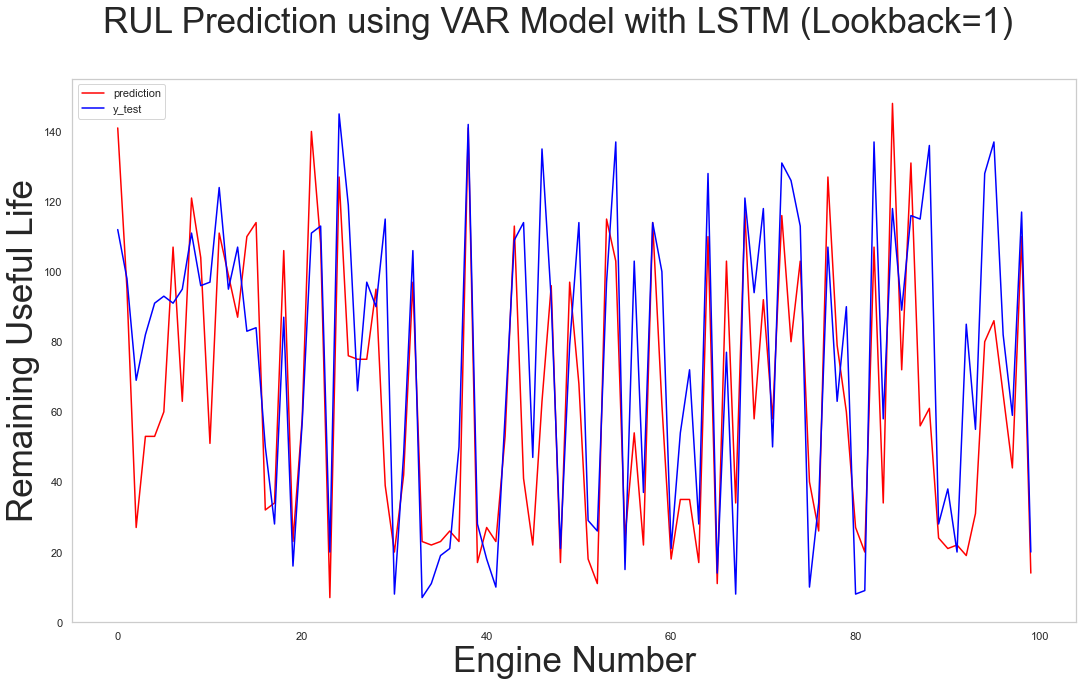

mean_squared_error >>  773.07
root_mean_squared_error >>  27.80413638291972
mean_absolute_error >> 21.45
scoring function >> 2131.5982643895677


In [273]:
model = load_model('LSTM_with_lookback_1.h5')

lookback = 1
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

df_test_rul = pd.read_csv(RUL_file, names=['rul'])
df_test_rul.head()

RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

print(max_cycles)

df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

test_data = []
i = 0
count = 0
while i < len(df_test):
    temp = []
    j = int(max_cycles[count])
    count = count+1
    #print(j)
    if j == 0:
        break
    while j!=0:
        temp.append(df_test[i])
        i=i+1
        j=j-1
    test_data.append(temp)

print(len(test_data))

y_new = []
for i in range(len(test_data)):
    y_new.append(pd.DataFrame(test_data[i]))

y_new[1]

predictions = []
for i in range(len(y_new)):
    test_model = VAR(y_new[i][0:len(y_new[i])-lookback])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=1)
    predictions.append(test_pred)

predictions = np.array(predictions)

predictions.shape

lstm_pred = model.predict(predictions)

lstm_pred = np.array(lstm_pred)
for i in range(100):
    lstm_pred[i] = int(lstm_pred[i])

len(lstm_pred)

y_test = np.array(df_test_rul)

len(y_test)

fig = plt.figure(figsize=(18,10))
plt.plot(lstm_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using VAR Model with LSTM (Lookback=1)', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

print("mean_squared_error >> ", mean_squared_error(y_test,lstm_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,lstm_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,lstm_pred))
print("scoring function >>",scoring_function(y_test,lstm_pred))



Text(0, 0.5, 'Remaining Useful Life')

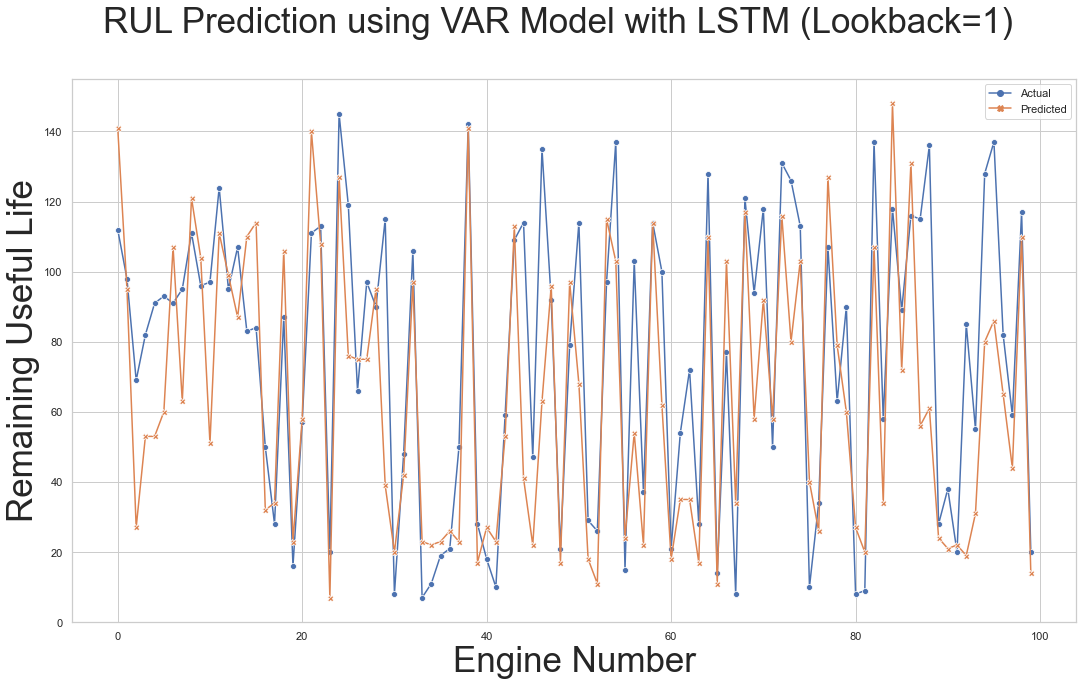

In [274]:
df=pd.DataFrame(np.arange(1,101))
df['Actual']=y_test
df['Predicted']=lstm_pred
df=df.drop([0],axis=1)

sns.set_theme(style="whitegrid")
a4_dims = (18,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)

fig.suptitle('RUL Prediction using VAR Model with LSTM (Lookback=1)', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

# 2. Lookback = 5

In [285]:
model = load_model('LSTM_with_lookback_5.h5')
lookback = 5
lookback

5

In [286]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [287]:
df_test_rul = pd.read_csv(RUL_file, names=['rul'])
df_test_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [288]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

In [289]:
print(max_cycles)

[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [290]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [291]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [292]:
test_data = []
i = 0
count = 0
while i < len(df_test):
    temp = []
    j = int(max_cycles[count])
    count = count+1
    #print(j)
    if j == 0:
        break
    while j!=0:
        temp.append(df_test[i])
        i=i+1
        j=j-1
    test_data.append(temp)

In [293]:
print(len(test_data))

100


In [294]:
y_new = []
for i in range(len(test_data)):
    y_new.append(pd.DataFrame(test_data[i]))

y_new[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.793850,-0.403908,1.327938,0.491476,0.264432,0.414832,-0.930599,0.549425,-2.091438,0.139549,-0.291073,1.195698,-0.972686,0.128797,-0.435852,0.748684,0.655920
1,-1.759832,-0.494678,0.677007,0.124510,0.091941,0.167868,-0.390194,0.039405,-0.328605,0.240686,0.447638,0.209360,-2.364091,0.569061,0.378493,-0.405454,-0.574031
2,-1.726093,0.095455,1.004600,0.297019,1.470300,0.931735,-0.658122,1.031562,-2.687990,0.240686,-0.852788,0.209360,-1.352862,-1.645776,1.148940,0.899581,0.835040
3,-1.692628,1.140251,0.344897,-0.381088,-0.930734,0.567578,0.546454,1.186557,-1.118874,0.088446,-0.378925,-0.143646,-0.931472,0.329208,0.378493,-0.543059,1.669632
4,-1.659435,0.186271,-1.395065,0.754319,-0.597428,0.477975,0.280052,1.031562,-1.535407,0.340425,-0.343903,0.715408,-1.316947,0.004742,-0.435852,-0.611304,0.620619
5,-1.626511,-0.358520,-1.035151,0.099683,-1.694581,-0.320162,-0.009098,0.713093,-1.742885,0.956764,0.033405,-0.143646,-1.073174,-0.222763,-0.435852,-0.813804,-0.816911
6,-1.593852,0.867611,0.007977,0.418886,1.223617,0.154514,-0.347077,1.186557,-0.729036,0.583861,-1.357336,0.034494,-1.308691,-0.469407,0.378493,-1.012946,2.391391
7,-1.561456,0.685883,1.004600,0.370273,-0.972818,0.034889,-0.903790,0.039405,-0.677335,0.036981,-0.112400,1.350488,-0.355285,0.621678,-1.300958,-0.746677,-1.308672
8,-1.529320,-0.993778,1.004600,-0.458622,0.153580,0.469392,-0.781945,0.382663,-0.596323,0.340425,-0.534577,0.209360,-0.730091,0.716429,-0.435852,-1.273230,-0.769650
9,-1.497440,0.958485,1.327938,0.174027,0.571892,0.251963,-0.504089,0.873772,-0.308210,0.340425,-1.172699,0.549714,-1.790488,-0.120693,-0.435852,0.159801,0.009971


In [248]:
predictions = []
for i in range(100):
    test_model = VAR(y_new[i][0:len(y_new[i])-lookback])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=5)
    predictions.append(test_pred)

In [249]:
predictions = np.array(predictions)

In [296]:
predictions.shape

(100, 1, 17)

In [297]:
lstm_pred = model.predict(predictions)

In [298]:
(lstm_pred.shape)

(100, 1)

In [299]:
y_test = np.array(df_test_rul)

In [300]:
len(y_test)

100

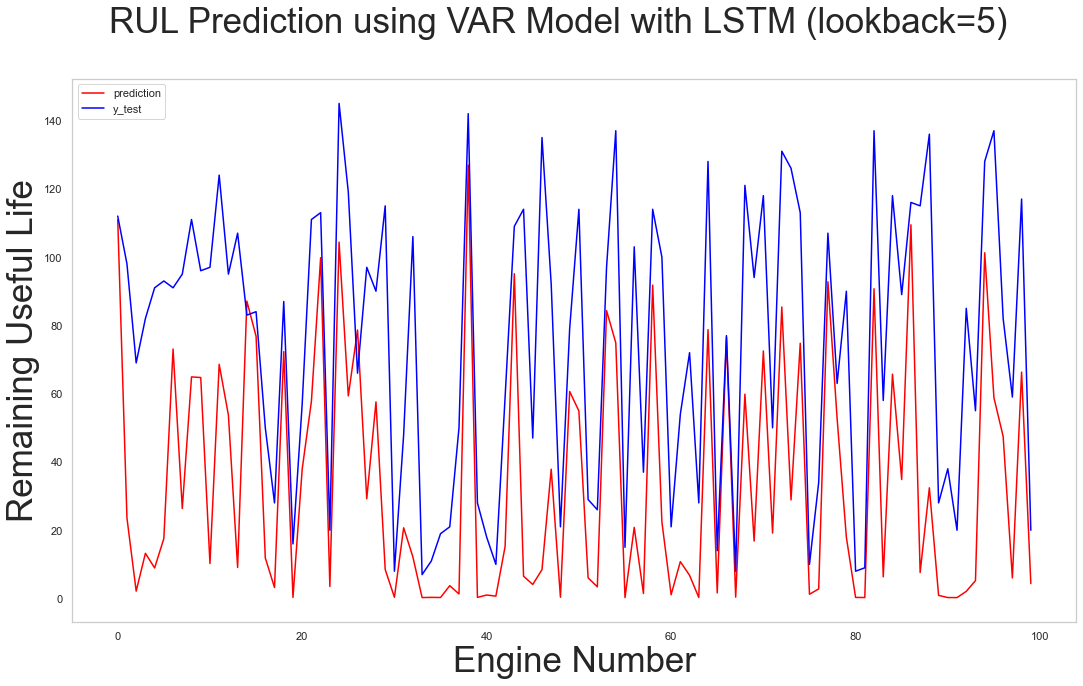

In [301]:
fig = plt.figure(figsize=(18,10))
plt.plot(lstm_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using VAR Model with LSTM (lookback=5)', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

Text(0, 0.5, 'Remaining Useful Life')

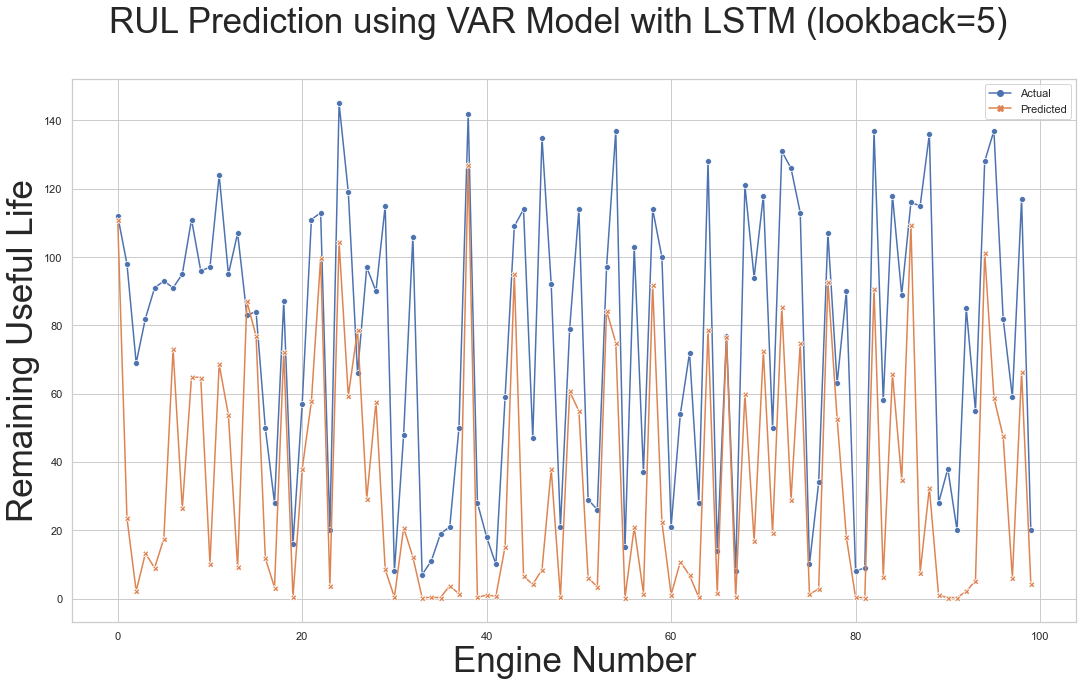

In [302]:
df=pd.DataFrame(np.arange(1,101))
df['Actual']=y_test
df['Predicted']=lstm_pred
df=df.drop([0],axis=1)

sns.set_theme(style="whitegrid")
a4_dims = (18,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)

fig.suptitle('RUL Prediction using VAR Model with LSTM (lookback=5)', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

In [303]:
def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

print("mean_squared_error >> ", mean_squared_error(y_test,lstm_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,lstm_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,lstm_pred))
print("scoring function >>",scoring_function(y_test,lstm_pred))

mean_squared_error >>  2589.959482628705
root_mean_squared_error >>  50.89164452666768
mean_absolute_error >> 41.509726392030714
scoring function >> 43056.87897162862


# 3. Lookback = 10

[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]
100


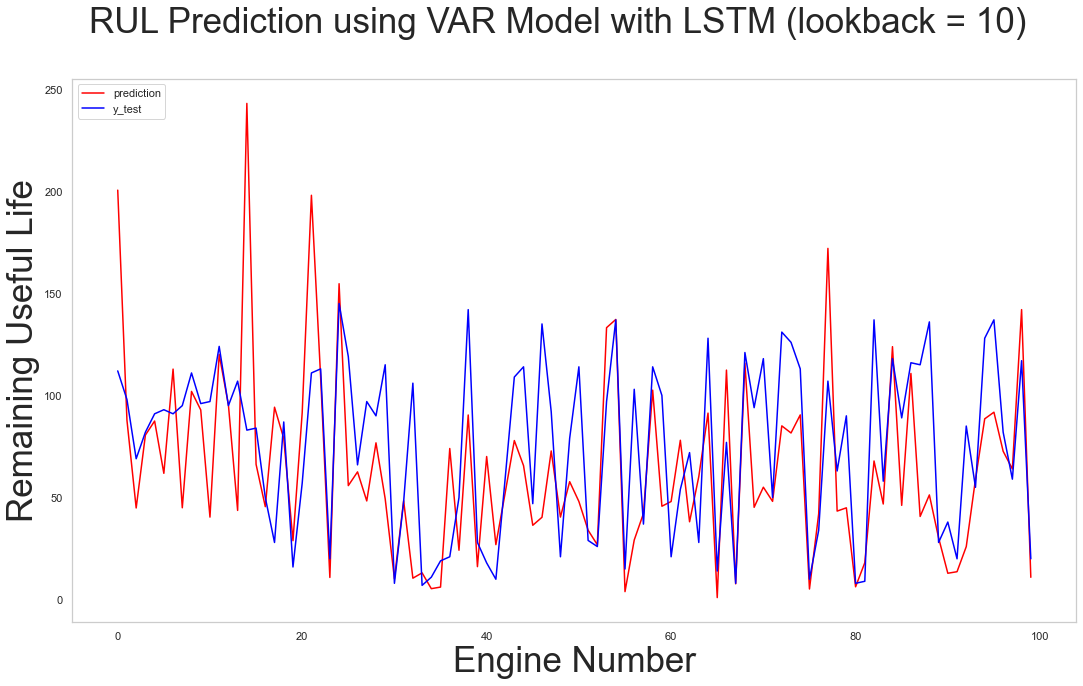

mean_squared_error >>  1688.707358792922
root_mean_squared_error >>  41.09388468851444
mean_absolute_error >> 29.3475936961174
scoring function >> 8879551.749355618


In [304]:
model = load_model('LSTM_with_lookback_10.h5')
lookback = 10
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

df_test_rul = pd.read_csv(RUL_file, names=['rul'])
df_test_rul.head()

RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

print(max_cycles)

df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

test_data = []
i = 0
count = 0
while i < len(df_test):
    temp = []
    j = int(max_cycles[count])
    count = count+1
    #print(j)
    if j == 0:
        break
    while j!=0:
        temp.append(df_test[i])
        i=i+1
        j=j-1
    test_data.append(temp)

print(len(test_data))

y_new = []
for i in range(len(test_data)):
    y_new.append(pd.DataFrame(test_data[i]))

y_new[1]

predictions = []
for i in range(100):
    test_model = VAR(y_new[i][0:len(y_new[i])-lookback])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=10)
    predictions.append(test_pred)

predictions = np.array(predictions)

predictions.shape

lstm_pred = model.predict(predictions)



(lstm_pred.shape)

y_test = np.array(df_test_rul)

len(y_test)

fig = plt.figure(figsize=(18,10))
plt.plot(lstm_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using VAR Model with LSTM (lookback = 10)', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

print("mean_squared_error >> ", mean_squared_error(y_test,lstm_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,lstm_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,lstm_pred))
print("scoring function >>",scoring_function(y_test,lstm_pred))





Text(0, 0.5, 'Remaining Useful Life')

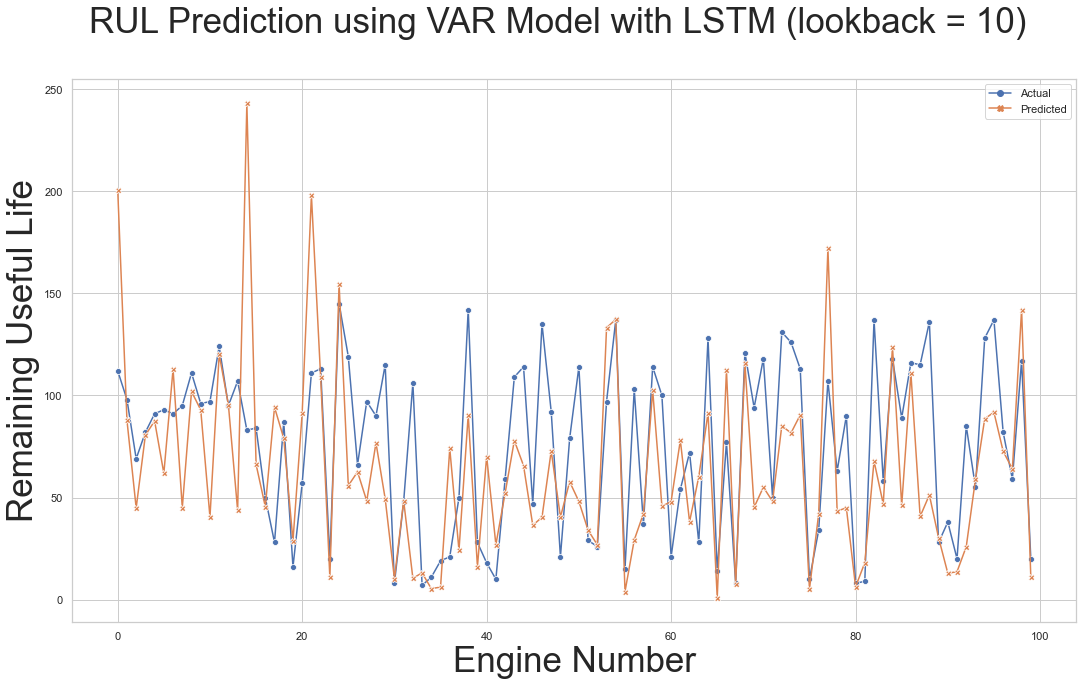

In [305]:
df=pd.DataFrame(np.arange(1,101))
df['Actual']=y_test
df['Predicted']=lstm_pred
df=df.drop([0],axis=1)

sns.set_theme(style="whitegrid")
a4_dims = (18,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)

fig.suptitle('RUL Prediction using VAR Model with LSTM (lookback = 10)', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

# 4 Lookback = 20

[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]
100


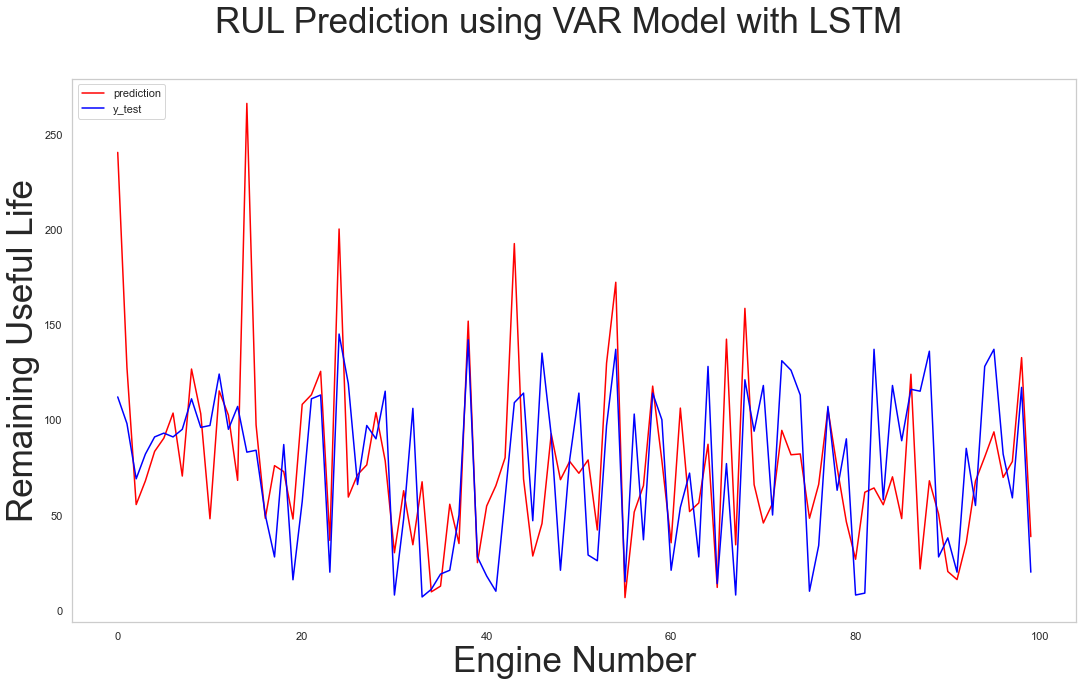

mean_squared_error >>  1796.082876926837
root_mean_squared_error >>  42.380217990553525
mean_absolute_error >> 31.528484373092653
scoring function >> 89713080.2299759


In [306]:
model = load_model('LSTM_with_lookback_20.h5')
lookback = 20
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

df_test_rul = pd.read_csv(RUL_file, names=['rul'])
df_test_rul.head()

RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

print(max_cycles)

df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

test_data = []
i = 0
count = 0
while i < len(df_test):
    temp = []
    j = int(max_cycles[count])
    count = count+1
    #print(j)
    if j == 0:
        break
    while j!=0:
        temp.append(df_test[i])
        i=i+1
        j=j-1
    test_data.append(temp)

print(len(test_data))

y_new = []
for i in range(len(test_data)):
    y_new.append(pd.DataFrame(test_data[i]))

y_new[1]

predictions = []
for i in range(100):
    test_model = VAR(y_new[i][0:len(y_new[i])-lookback])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=20)
    predictions.append(test_pred)

predictions = np.array(predictions)

predictions.shape

lstm_pred = model.predict(predictions)



(lstm_pred.shape)

y_test = np.array(df_test_rul)

len(y_test)

fig = plt.figure(figsize=(18,10))
plt.plot(lstm_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using VAR Model with LSTM', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

print("mean_squared_error >> ", mean_squared_error(y_test,lstm_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,lstm_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,lstm_pred))
print("scoring function >>",scoring_function(y_test,lstm_pred))

Text(0, 0.5, 'Remaining Useful Life')

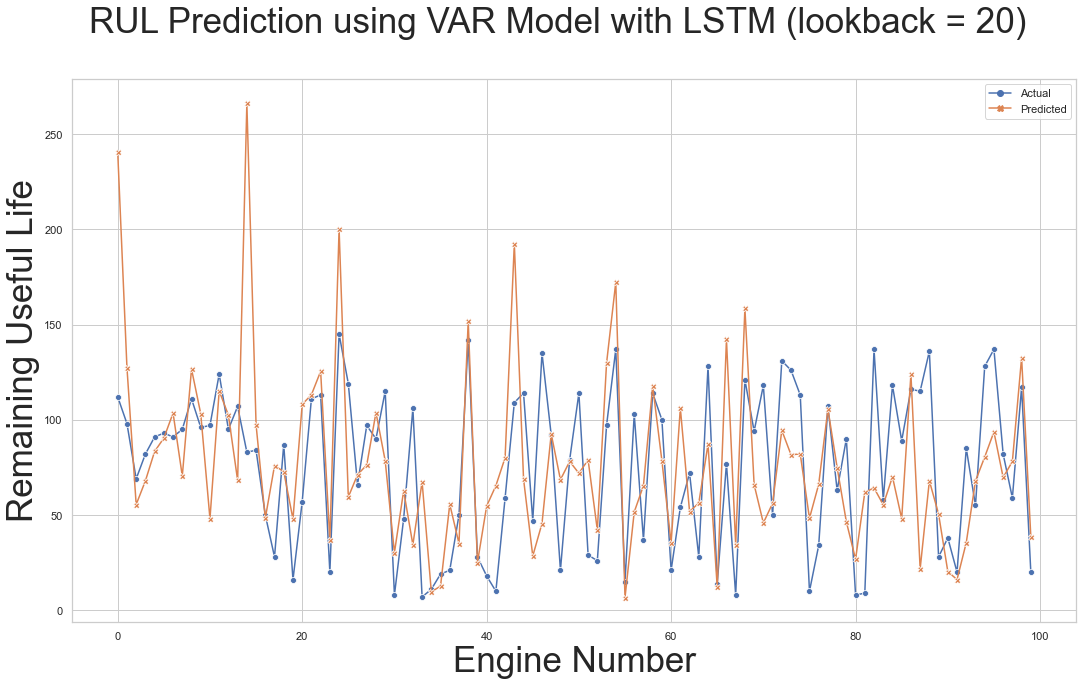

In [307]:
df=pd.DataFrame(np.arange(1,101))
df['Actual']=y_test
df['Predicted']=lstm_pred
df=df.drop([0],axis=1)

sns.set_theme(style="whitegrid")
a4_dims = (18,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)

fig.suptitle('RUL Prediction using VAR Model with LSTM (lookback = 20)', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)